In [1]:
import random
import time
import math
import sympy
from sympy.ntheory import primitive_root
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import signal

In [2]:
MAX_BITS = 0
TIMEOUT = 0

In [3]:
class TimeoutException(Exception):   # Custom exception class
    pass

def timeout_handler(signum, frame):   # Custom signal handler
    raise TimeoutException

# Change the behavior of SIGALRM
signal.signal(signal.SIGALRM, timeout_handler)

<Handlers.SIG_DFL: 0>

In [4]:
def generate_prime(bits):
    """Генерация простого числа заданного порядка (количество бит)"""
    return sympy.randprime(2**(bits-1), 2**bits)

def find_primitive_root(p):
    """Нахождение примитивного элемента мультипликативной группы Z_p*"""
    return primitive_root(p)

def mod_pow(base, exponent, modulus):
    """Быстрое возведение в степень по модулю"""
    return pow(base, exponent, modulus)

In [5]:
# ================================
# 1. Алгоритм Brute Force
# ================================

def brute_force_dlog(p, g, y, timeout=60) -> tuple[int|None, float]:
    """Поиск дискретного логарифма методом перебора"""
    start_time = time.time()
    current = 1
    
    for x in range(0, p-1):
        if time.time() - start_time > timeout:
            return None, time.time() - start_time
            
        current = (current * g) % p
        if current == y:
            return x, time.time() - start_time
    
    return None, time.time() - start_time

In [6]:
# ================================
# 2. Алгоритм Гельфонда-Шенкса (Baby-step Giant-step)
# ================================

def baby_step_giant_step(p, g, y, timeout=60) -> tuple[int|None, float]:
    """Алгоритм Гельфонда-Шенкса (Baby-step Giant-step)"""
    start_time = time.time()
    
    m = int(math.isqrt(p - 1)) + 1
    
    # Baby steps
    baby_steps = {}
    current = 1
    for j in range(m):
        if time.time() - start_time > timeout:
            return None, time.time() - start_time
        baby_steps[current] = j
        current = (current * g) % p
    
    # Вычисление g^{-m}
    gm_inv = pow(g, m * (p - 2), p)  # g^{-m} mod p через малую теорему Ферма
    
    # Giant steps
    current = y
    for i in range(m):
        if time.time() - start_time > timeout:
            return None, time.time() - start_time
            
        if current in baby_steps:
            x = i * m + baby_steps[current]
            if x < p - 1:  # Проверка, что x в правильном диапазоне
                return x, time.time() - start_time
        
        current = (current * gm_inv) % p
    
    return None, time.time() - start_time

In [7]:
# ================================
# 3. Алгоритм Ро Полларда
# ================================

def pollard_rho_dlog(p, g, y, timeout=60):
    """Алгоритм Ро Полларда - простая и надежная реализация"""
    start_time = time.time()
    
    n = p - 1  # порядок группы
    
    # Случайное начальное значение
    x = random.randint(1, n-1)
    a = random.randint(0, n-1)
    b = random.randint(0, n-1)
    
    X, A, B = x, a, b  # Для быстрого зайца
    
    def next_val(xab):
        x, a, b = xab
        s = x % 3
        
        if s == 0:
            # S1: умножение на y
            return (x * y) % p, a, (b + 1) % n
        elif s == 1:
            # S2: возведение в квадрат
            return (x * x) % p, (2 * a) % n, (2 * b) % n
        else:
            # S3: умножение на g
            return (x * g) % p, (a + 1) % n, b
    
    iteration = 0
    while iteration < 1000000:  # Защита от бесконечного цикла
        if time.time() - start_time > timeout:
            return None, time.time() - start_time
        
        iteration += 1
        
        # Медленная черепаха - один шаг
        x, a, b = next_val((x, a, b))
        
        # Быстрый заяц - два шага
        X, A, B = next_val((X, A, B))
        X, A, B = next_val((X, A, B))
        
        # Проверяем столкновение
        if x == X:
            # Нашли цикл, решаем: g^a * y^b = g^A * y^B
            # => a + x*b ≡ A + x*B (mod n)
            # => x*(b - B) ≡ A - a (mod n)
            
            db = (b - B) % n
            da = (A - a) % n
            
            if db == 0:
                if da == 0:
                    # Случайное совпадение, продолжаем
                    continue
                else:
                    # Нет решений
                    return None, time.time() - start_time
            
            # Решаем линейное сравнение
            gcd_val = math.gcd(db, n)
            
            if gcd_val == 1:
                # Единственное решение
                try:
                    x_solution = (da * pow(db, -1, n)) % n
                    # Проверяем решение
                    if pow(g, x_solution, p) == y:
                        return x_solution, time.time() - start_time
                except:
                    continue
            else:
                # Несколько решений
                m = n // gcd_val
                try:
                    inv = pow(db // gcd_val, -1, m)
                    x0 = (da // gcd_val * inv) % m
                    
                    # Проверяем все возможные решения
                    for k in range(gcd_val):
                        x_solution = (x0 + k * m) % n
                        if pow(g, x_solution, p) == y:
                            return x_solution, time.time() - start_time
                except:
                    continue
    
    return None, time.time() - start_time

In [8]:
def launch_algorithm(func, *args):
    result = (None, 60)
    try:
        signal.alarm(TIMEOUT)
        result = func(*args)
    except TimeoutException:
        return result
    finally:
        signal.alarm(0)
        return result

In [9]:
# ================================
# Основной эксперимент
# ================================

def run_experiment(max_bits=30, timeout_per_algorithm=60):
    """Запуск эксперимента для разных размеров простых чисел"""
    
    results = {
        'brute_force': defaultdict(list),
        'baby_giant': defaultdict(list),
        'pollard_rho': defaultdict(list)
    }
    
    bits_range = list(range(8, max_bits + 1, 2))
    
    for bits in bits_range:
        print(f"\n{'='*60}")
        print(f"Тестирование для порядка {bits} бит")
        print(f"{'='*60}")
        
        try:
            # 1. Генерация параметров
            print(f"Генерация простого числа {bits} бит...")
            p = generate_prime(bits)
            print(f"p = {p} (бит: {p.bit_length()})")
            
            # 2. Поиск примитивного элемента
            print("Поиск примитивного элемента...")
            g = find_primitive_root(p)
            print(f"g = {g}")
            
            # 3. Генерация секретного ключа
            x_secret = random.randint(2, p - 2)
            print(f"Секретный ключ x = {x_secret}")
            
            # 4. Вычисление открытого ключа
            y = mod_pow(g, x_secret, p)
            print(f"Открытый ключ y = {y}")
            
            # 5. Запуск алгоритмов
            print("\nЗапуск алгоритмов:")
            
            # Brute Force
            print("1. Brute Force...")
            # x_bf, time_bf = brute_force_dlog(p, g, y, timeout_per_algorithm)
            x_bf, time_bf = launch_algorithm(brute_force_dlog, p, g, y, timeout_per_algorithm)
            if x_bf is not None:
                print(f"   Найдено: x = {x_bf}, время: {time_bf:.4f} сек")
                results['brute_force'][bits].append(time_bf)
            else:
                print(f"   Таймаут ({timeout_per_algorithm} сек)")
                results['brute_force'][bits].append(timeout_per_algorithm)
            
            # Baby-step Giant-step
            print("2. Baby-step Giant-step...")
            # x_bg, time_bg = baby_step_giant_step(p, g, y, timeout_per_algorithm)
            x_bg, time_bg = launch_algorithm(baby_step_giant_step, p, g, y, timeout_per_algorithm)
            if x_bg is not None:
                print(f"   Найдено: x = {x_bg}, время: {time_bg:.4f} сек")
                results['baby_giant'][bits].append(time_bg)
            else:
                print(f"   Таймаут ({timeout_per_algorithm} сек)")
                results['baby_giant'][bits].append(timeout_per_algorithm)
            
            # Pollard's Rho
            print("3. Pollard's Rho...")
            # x_pr, time_pr = pollard_rho_dlog(p, g, y, timeout_per_algorithm)
            x_pr, time_pr = launch_algorithm(pollard_rho_dlog, p, g, y, timeout_per_algorithm)
            if x_pr is not None:
                print(f"   Найдено: x = {x_pr}, время: {time_pr:.4f} сек")
                results['pollard_rho'][bits].append(time_pr)
            else:
                print(f"   Таймаут ({timeout_per_algorithm} сек)")
                results['pollard_rho'][bits].append(timeout_per_algorithm)
                
        except Exception as e:
            print(f"Ошибка для {bits} бит: {e}")
            continue
    
    return results, bits_range

In [10]:
# ================================
# Визуализация результатов
# ================================

def plot_results(results, bits_range):
    """Построение графиков результатов"""
    
    plt.figure(figsize=(14, 8))
    
    # Подготовка данных
    bf_times = []
    bg_times = []
    pr_times = []
    
    for bits in bits_range:
        if bits in results['brute_force']:
            bf_times.append(np.mean(results['brute_force'][bits]))
        else:
            bf_times.append(np.nan)
            
        if bits in results['baby_giant']:
            bg_times.append(np.mean(results['baby_giant'][bits]))
        else:
            bg_times.append(np.nan)
            
        if bits in results['pollard_rho']:
            pr_times.append(np.mean(results['pollard_rho'][bits]))
        else:
            pr_times.append(np.nan)
    
    # График в линейном масштабе
    plt.subplot(1, 2, 1)
    plt.plot(bits_range, bf_times, 'o-', label='Brute Force', linewidth=2)
    plt.plot(bits_range, bg_times, 's-', label='Baby-step Giant-step', linewidth=2)
    plt.plot(bits_range, pr_times, '^-', label="Pollard's Rho", linewidth=2)
    plt.xlabel('Порядок (бит)')
    plt.ylabel('Время выполнения (сек)')
    plt.title('Сравнение алгоритмов вычисления дискретного логарифма')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # График в логарифмическом масштабе по оси Y
    plt.subplot(1, 2, 2)
    plt.semilogy(bits_range, bf_times, 'o-', label='Brute Force', linewidth=2)
    plt.semilogy(bits_range, bg_times, 's-', label='Baby-step Giant-step', linewidth=2)
    plt.semilogy(bits_range, pr_times, '^-', label="Pollard's Rho", linewidth=2)
    plt.xlabel('Порядок (бит)')
    plt.ylabel('Время выполнения (сек, log scale)')
    plt.title('Логарифмическая шкала')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('dlog_algorithms_comparison.png', dpi=150)
    plt.show()
    
    # Вывод таблицы результатов
    print("\n" + "="*80)
    print("РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА")
    print("="*80)
    print(f"{'Бит':>6} | {'Brute Force':>12} | {'Baby-Giant':>12} | {'Pollard Rho':>12}")
    print("-"*60)
    
    for i, bits in enumerate(bits_range):
        print(f"{bits:>6} | {bf_times[i]:>12.4f} | {bg_times[i]:>12.4f} | {pr_times[i]:>12.4f}")



ЭКСПЕРИМЕНТ: Сравнение алгоритмов вычисления дискретного логарифма
Таймаут на алгоритм: 60 сек
Максимальный порядок: 60 бит


Тестирование для порядка 8 бит
Генерация простого числа 8 бит...
p = 193 (бит: 8)
Поиск примитивного элемента...
g = 5
Секретный ключ x = 51
Открытый ключ y = 104

Запуск алгоритмов:
1. Brute Force...
   Найдено: x = 50, время: 0.0000 сек
2. Baby-step Giant-step...
   Найдено: x = 51, время: 0.0000 сек
3. Pollard's Rho...
   Таймаут (60 сек)

Тестирование для порядка 10 бит
Генерация простого числа 10 бит...
p = 919 (бит: 10)
Поиск примитивного элемента...
g = 7
Секретный ключ x = 775
Открытый ключ y = 894

Запуск алгоритмов:
1. Brute Force...
   Найдено: x = 774, время: 0.0001 сек
2. Baby-step Giant-step...
   Найдено: x = 775, время: 0.0000 сек
3. Pollard's Rho...
   Таймаут (60 сек)

Тестирование для порядка 12 бит
Генерация простого числа 12 бит...
p = 2333 (бит: 12)
Поиск примитивного элемента...
g = 2
Секретный ключ x = 988
Открытый ключ y = 1061

Запуск а

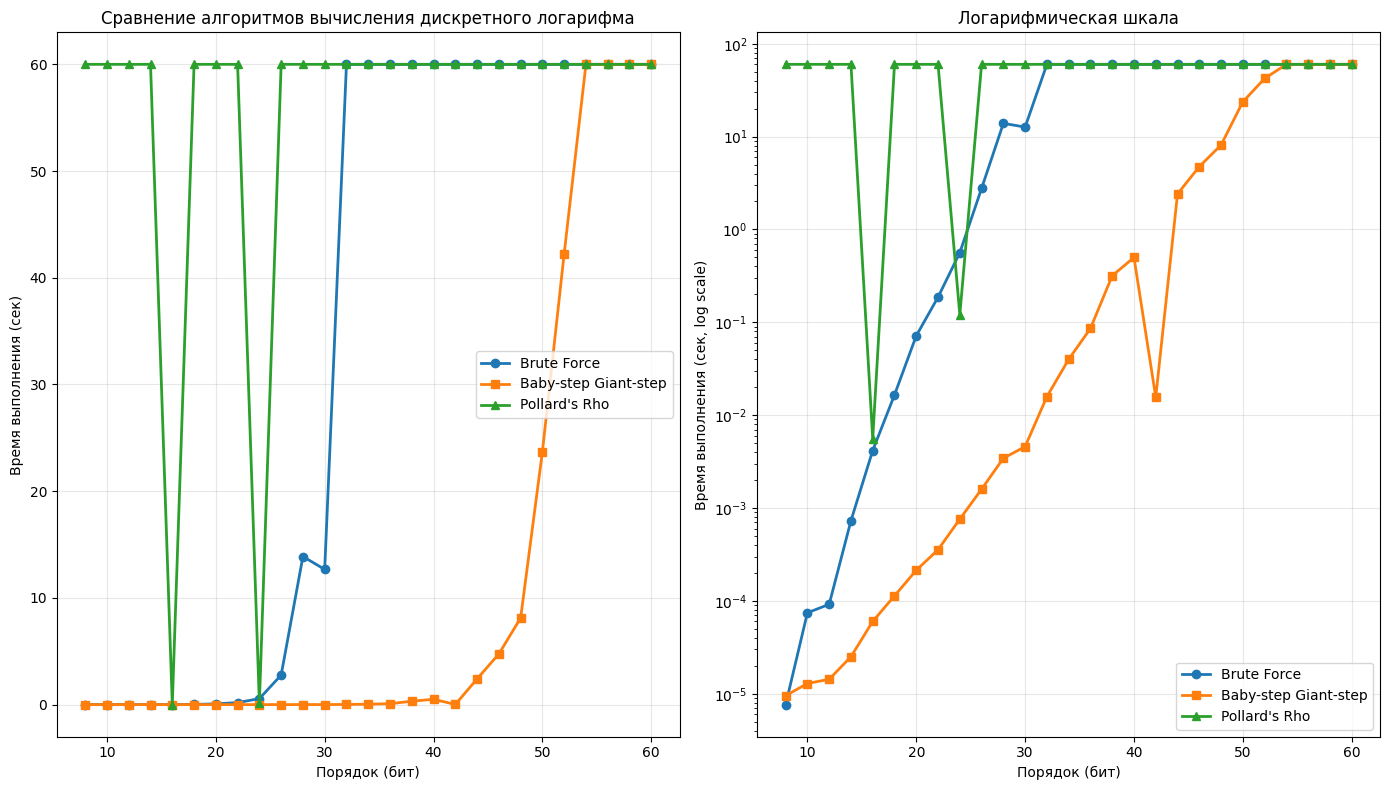


РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА
   Бит |  Brute Force |   Baby-Giant |  Pollard Rho
------------------------------------------------------------
     8 |       0.0000 |       0.0000 |      60.0000
    10 |       0.0001 |       0.0000 |      60.0000
    12 |       0.0001 |       0.0000 |      60.0000
    14 |       0.0007 |       0.0000 |      60.0000
    16 |       0.0042 |       0.0001 |       0.0056
    18 |       0.0165 |       0.0001 |      60.0000
    20 |       0.0716 |       0.0002 |      60.0000
    22 |       0.1866 |       0.0004 |      60.0000
    24 |       0.5627 |       0.0008 |       0.1203
    26 |       2.7674 |       0.0016 |      60.0000
    28 |      13.8772 |       0.0034 |      60.0000
    30 |      12.6718 |       0.0046 |      60.0000
    32 |      60.0000 |       0.0158 |      60.0000
    34 |      60.0000 |       0.0399 |      60.0000
    36 |      60.0000 |       0.0858 |      60.0000
    38 |      60.0000 |       0.3172 |      60.0000
    40 |      60.0000 |       

In [11]:
# ================================
# Запуск эксперимента
# ================================

if __name__ == "__main__":
    # Настройки эксперимента
    MAX_BITS = 60  # Максимальный порядок (бит)
    TIMEOUT = 60   # Таймаут для каждого алгоритма в секундах
    
    print("ЭКСПЕРИМЕНТ: Сравнение алгоритмов вычисления дискретного логарифма")
    print(f"Таймаут на алгоритм: {TIMEOUT} сек")
    print(f"Максимальный порядок: {MAX_BITS} бит\n")
    
    # Запуск эксперимента
    results, bits_range = run_experiment(max_bits=MAX_BITS, timeout_per_algorithm=TIMEOUT)
    
    # Построение графиков
    plot_results(results, bits_range)